In [1]:
from utils import *
from fluxtower_parse import *
import numpy as np      
import datetime as dt
from scipy.signal import medfilt, detrend, coherence, windows

In [74]:
# Get Metek data

# If metek files don't already exsist, extract using the below:

# To update raw data files: 
# rsync -azvp fluxtower@192.168.1.211:/home/data/fluxtower_data_transfer/ /Users/heather/ICECAPS-ACE/Data/.

# To extract metek files:
#dname = 'metek'
#dloc = '/Users/heather/ICECAPS-ACE/Data/'
#extract_out = '/Users/heather/ICECAPS-ACE/temp_data/'
#extract_tar(dloc,extract_out,dname)

# If extracted files already exist, just give the d loction:
dpath = '/Users/heather/ICECAPS-ACE/Data/'
log_metek = '/Users/heather/ICECAPS-ACE/log_metek.txt'

# Start and stop date:
start = dt.datetime(2019,8,31,0,0)
stop = dt.datetime(2019,9,1,0,0)

# Parse data into dataframe using the following function from fluxtower parse:
m1,m2 = extract_metek_data(start,stop,dpath,log_metek)

In [75]:
# Clean Metek data
# Based on clean_metek.m by IAM, 25/7/2014
# metek = clean_metek(metek)
# INPUT
#  metek  - data strucure
# OUTPUT
#  metek  - data structure
# wind compents and sonic temperature are cleaned up:
# - the time series are filtered for outliers, these are replaced with  
#   median filtered values
# - missing values from error messages (NaNs) are then interpolated over? - not done yet


# filter for clear outliers - replace with median filtered values
#set limit at 3*standard deviation of vertical wind component

jj = ~np.isnan(m1.z) # Not nan indices
m1_sd = np.std(m1.z[jj]) # standard deviation of vertical wind component. 

jj = ~np.isnan(m2.z) # Not nan indices
m2_sd = np.std(m2.z[jj]) # standard deviation of vertical wind component. 

# replace outliers with median filter
def replace_outliers(var,sd):
    var=var.astype(float)
    jj = ~np.isnan(var) # Ignore nans
    temp = var[jj]
    mf = medfilt(temp,11)             # Get median filter
    ii = np.abs(temp - mf) > 3*sd     # Get outliers, where greated than 3 Sd's from median
    temp[ii] = mf[ii]                 # Replace these outliers with the median
    var_clean = var
    var_clean[jj] = temp      # Put back into orginal array/
    
    return var_clean

m1['x_clean']=replace_outliers(m1['x'],m1_sd)
m1['y_clean']=replace_outliers(m1['y'],m1_sd)
m1['z_clean']=replace_outliers(m1['z'],m1_sd)
m1['T_clean']=replace_outliers(m1['T'],m1_sd)

m2['x_clean']=replace_outliers(m2['x'],m2_sd)
m2['y_clean']=replace_outliers(m2['y'],m2_sd)
m2['z_clean']=replace_outliers(m2['z'],m2_sd)
m2['T_clean']=replace_outliers(m2['T'],m2_sd)

# patch up missing data from records with error messages by interpolation
# metek output should be 10Hz
# 10Hz = 0.1s = 100 ms
m1 = m1.resample('100L').mean().interpolate()
m2 = m2.resample('100L').mean().interpolate()
#f.set_index('DateTime')['Value'].resample('1H').mean().interpolate()


In [76]:
# Do cross wind temperature correction
# Adapted from Ts_sidewind_correction.m by IMB July 2007
#     Correct contamination of sonic temperature measurement for lengthening of
#     sonic path by sidewind. 
#
#function T = Ts_sidewind_correction(Ts,u,v,w,model);
# INPUTS
#  Ts    : sonic temperature (K)
#  u,v,w : wind components in sonic measurement frame (before any rotations,
#          motion correction, etc) (m/s)

# OUTPUT
#  T     : corrected temperature (K)
#
#     Correction follows van Dijk et al. 2004: The
#     principles of surface flux physics: theory, practice and description of
#     the ECPACK library (www.met.wau.nl/projects/jep). See also: Liu et al.
#     2001: BLM, 100, 459-468, and Schotanus et al. 1983: BLM, 26, 81-93.

def Ts_sidewind_correction(Ts,u,v,w):
    vn2 = (3/4)*(u**2 + v**2) + 0.5*w**2
    T = Ts + vn2/403
    return T

m1['T_corrected'] = Ts_sidewind_correction(m1['T_clean'].astype(float),m1['x'].astype(float),m1['y'].astype(float),m1['z'].astype(float))
m2['T_corrected'] = Ts_sidewind_correction(m2['T_clean'].astype(float),m2['x'].astype(float),m2['y'].astype(float),m2['z'].astype(float))

In [77]:
# Correct tilt and align with horizontal streamlinge over a single run (~20mins)
# Adapted from rotate_to_run.m by IMB July 2006
#% references:
#%  Wilczak et al. 2001: sonic anemometer tilt corrections. BLM, 99, 127-150
#%  (but beware typos in equations)
#%  Kaimal & Finnigan, 1994: Atmospheric Boundary Layer Flows: Their
#%  Structure and Measurement. Oxford University Press
#%  van Dijk et al. 2004: The principles of surface flux physics: theory,
#%  practice and description of the ECPACK library
#%  www.met.wau.nl/projects/jep

def rotate_to_run(um,vm,wm):
    #% First rotate to align x-axis with mean wind direction in sonic's
    #% reference frame
    
    theta=np.arctan2(np.mean(vm),np.mean(um))
    u1 = um*np.cos(theta) + vm*np.sin(theta)
    v1 = -um*np.sin(theta) + vm*np.cos(theta)
    w1 = wm

    #% Next rotate u and w so that x-axis lies along mean streamline and 
    #% mean(w) is zero

    phi = np.arctan2(np.mean(w1),np.mean(u1))
    u2 = u1*np.cos(phi) + w1*np.sin(phi)
    v2 = v1
    w2=  -u1*np.sin(phi) + w1*np.cos(phi)

    # Theta is angle of rotation um-to-vm (anticlockwise or righthanded)
    # to aign u with mean wind (degrees)
    theta = theta*180/np.pi

    # phi is tilt angle (+ve tilts x-axis upwards) to align x-axis with
    # mean streamline and force <w>=0
    phi = phi*180/np.pi

    # Output wind components in streamline oriented reference frame, theta and phi

    return u2,v2,w2,theta,phi

um = m1.x_clean # measured wind components in sonic reference fram
vm = m1.y_clean
wm = m1.z_clean

m1['u'],m1['v'],m1['w'],theta,phi = rotate_to_run(m1.x_clean,m1.y_clean,m1.z_clean)
m2['u'],m2['v'],m2['w'],theta,phi = rotate_to_run(m2.x_clean,m2.y_clean,m2.z_clean)

In [ ]:
# Use snow depth sensor to do absolute height correction

In [ ]:
# Calculate bulk richardson number

In [78]:
# Calculate cospectral density and ogive function. 

# Calculated using mathematical methods, fast fourie transform
# FFT gives the amplitudes of variation for different frequencies

# Co-spectra: how much different sized eddies contribute to the covariance of two variables - the product of the fft of two variables. 

# Ogive = cumulative co-spectrum. Use to find the point after which there is no flux contribution. Averaging peroiod should be longer
# than this so large eddies aren't lost, but otherwise as short as possible so that large scale changes (atmospheric) aren't included. 

# Choose your two variables. 
x = m1['T_corrected']
y = m1['w']

sf = 0.1 # Sampling frequency
m = len(x) # Number of points used in fourier transfer, can be length of time series or less.
noverlap = 1 # Number of points that each fft overlaps. 






In [83]:

# Calculate the cospectral density
# Uses linear detrend.
# Uses boxcar (rectangular) window.
window = windows.boxcar(m)
f,Cxy = coherence(x, y, sf, detrend='linear', window='boxcar',noverlap=noverlap)#,nperseg=m)

# Ogive

n = len(Cxy)
ogive = np.zeros(n)
ogive[0]=(Cxy*df)[0]
for i in range(1,n):
    k=n-1-i
    ogive[k]=ogive[k+1]+(Cxy*df)[k]

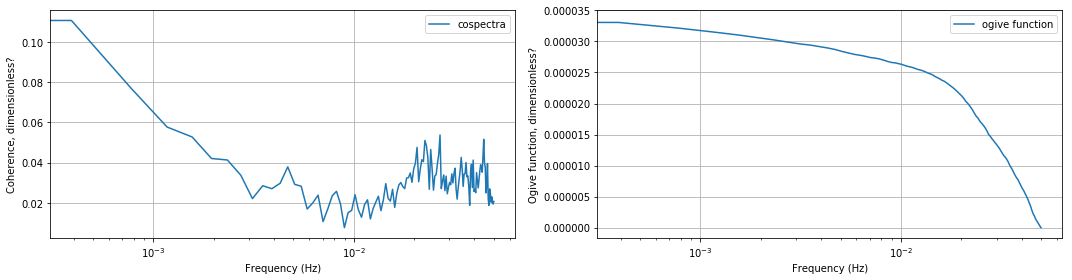

In [84]:


fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
ax1.grid(True)
ax1.semilogx(f,Cxy,label='cospectra')
ax1.set_ylabel('Coherence, dimensionless?')
ax1.set_xlabel('Frequency (Hz)')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(True)
ax2.semilogx(f,ogive,label='ogive function')
ax2.set_ylabel('Ogive function, dimensionless?')
ax2.set_xlabel('Frequency (Hz)')
ax2.legend()

#ax.set_xlim(d1,d2)
fig.tight_layout()



In [60]:
f

array([0.        , 0.00039063, 0.00078125, 0.00117188, 0.0015625 ,
       0.00195312, 0.00234375, 0.00273438, 0.003125  , 0.00351563,
       0.00390625, 0.00429688, 0.0046875 , 0.00507813, 0.00546875,
       0.00585938, 0.00625   , 0.00664063, 0.00703125, 0.00742188,
       0.0078125 , 0.00820313, 0.00859375, 0.00898438, 0.009375  ,
       0.00976562, 0.01015625, 0.01054688, 0.0109375 , 0.01132813,
       0.01171875, 0.01210938, 0.0125    , 0.01289063, 0.01328125,
       0.01367188, 0.0140625 , 0.01445313, 0.01484375, 0.01523438,
       0.015625  , 0.01601563, 0.01640625, 0.01679687, 0.0171875 ,
       0.01757812, 0.01796875, 0.01835938, 0.01875   , 0.01914063,
       0.01953125, 0.01992188, 0.0203125 , 0.02070313, 0.02109375,
       0.02148438, 0.021875  , 0.02226563, 0.02265625, 0.02304688,
       0.0234375 , 0.02382813, 0.02421875, 0.02460938, 0.025     ,
       0.02539062, 0.02578125, 0.02617188, 0.0265625 , 0.02695313,
       0.02734375, 0.02773438, 0.028125  , 0.02851563, 0.02890

In [78]:
(1/f[1])/60

42.666666666666664

In [70]:
f

array([0.        , 0.00039063, 0.00078125, 0.00117188, 0.0015625 ,
       0.00195312, 0.00234375, 0.00273438, 0.003125  , 0.00351563,
       0.00390625, 0.00429688, 0.0046875 , 0.00507813, 0.00546875,
       0.00585938, 0.00625   , 0.00664063, 0.00703125, 0.00742188,
       0.0078125 , 0.00820313, 0.00859375, 0.00898438, 0.009375  ,
       0.00976562, 0.01015625, 0.01054688, 0.0109375 , 0.01132813,
       0.01171875, 0.01210938, 0.0125    , 0.01289063, 0.01328125,
       0.01367188, 0.0140625 , 0.01445313, 0.01484375, 0.01523438,
       0.015625  , 0.01601563, 0.01640625, 0.01679687, 0.0171875 ,
       0.01757812, 0.01796875, 0.01835938, 0.01875   , 0.01914063,
       0.01953125, 0.01992188, 0.0203125 , 0.02070313, 0.02109375,
       0.02148438, 0.021875  , 0.02226563, 0.02265625, 0.02304688,
       0.0234375 , 0.02382813, 0.02421875, 0.02460938, 0.025     ,
       0.02539062, 0.02578125, 0.02617188, 0.0265625 , 0.02695313,
       0.02734375, 0.02773438, 0.028125  , 0.02851563, 0.02890